In [132]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
import itertools
import operator
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### **Read and clean data**

**Reading the relevant data** from European Center for Disease Control. The data includes COVID-19 Cases and Deaths for all countries.

Renaming colums and keeping data only for the 5 selected countries. Furthermore, the spread of COVID-19 in Europe and the US did not significantly take place before early March 2020 - as such we only focus on data from March and April 2020.

When considering the number of cases in the data, it is important to note, that different countries employ different strategies with respect to testing. As such, if a country tests rigorously it is bound to record more cases related to COVID-19. Therefore, we also consider the number of deaths related to COVID-19. Deaths related to COVID-19 can be considered as a constant rate of the *true* number of infected. Furthermore, it will not be conditioned on the number of tests being performed by each country.

In [133]:
# a. load
url = 'https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-2020-04-22.xlsx'
covid = pd.read_excel(url)

#In case of the URL not working, the dataframe can be loaded from the excel file provided:
#df = pd.read_excel('Covid_Data.xlsx')

# b. rename columns
covid.rename(columns = {'countryterritoryCode':'country', 'dateRep':'date'}, inplace=True)

drop_these = ['year', 'countriesAndTerritories', 'geoId', 'popData2018']
covid.drop(drop_these, axis=1, inplace=True) # axis = 1 -> columns, inplace=True -> changed, no copy made
covid.head(5)

#c. keeping the 5 relevant countries to be analyzed
array = ['ITA', 'ESP', 'DNK', 'SWE', 'USA']
covid = covid.loc[covid['country'].isin(array)]

#d. keeping the months of interest (March & April)
array2 = [3, 4]
covid = covid.loc[covid['month'].isin(array2)].reset_index()
drop_these = ['index']
covid.drop(drop_these, axis=1, inplace=True)

covid.head()

,date,day,month,cases,deaths,country,continentExp
0,2020-04-22,22,4,180,6,DNK,Europe
1,2020-04-21,21,4,131,9,DNK,Europe
2,2020-04-20,20,4,142,9,DNK,Europe
3,2020-04-19,19,4,169,10,DNK,Europe
4,2020-04-18,18,4,194,15,DNK,Europe


The order of the data is reversed, such that index 0 corresponds to the first date (1st of March) in our data.

In [134]:
covid = covid.iloc[::-1].reset_index()
drop_these = ['index']
covid.drop(drop_these, axis=1, inplace=True)
covid.head()

,date,day,month,cases,deaths,country,continentExp
0,2020-03-01,1,3,3,1,USA,America
1,2020-03-02,2,3,20,1,USA,America
2,2020-03-03,3,3,14,4,USA,America
3,2020-03-04,4,3,22,3,USA,America
4,2020-03-05,5,3,34,2,USA,America


To initially plot the number of confirmed COVID-19 cases and deaths in each country, we reformat the data as follows. Moreover, we are interested in accumulative data i.e. total number of cases and deaths on a given day. This is stored in covid_red.

In [163]:
covid_ref = pd.DataFrame()
#e. reformatting data for use in initial graphs
for country, group in covid.groupby("country"):
    if covid_ref.empty:
        covid_ref = group.set_index("date")[["cases", "deaths"]].rename(columns={"cases":country + " cases", "deaths":country + " deaths"})
    else:
        covid_ref = covid_ref.join(group.set_index("date")[["cases", "deaths"]].rename(columns={"cases":country + " cases", "deaths":country + " deaths"}))

#f. accumulative data
covid_ref = covid_ref.sort_values(by='date').cumsum()
covid_ref.head()

,DNK cases,DNK deaths,ESP cases,ESP deaths,ITA cases,ITA deaths,SWE cases,SWE deaths,USA cases,USA deaths
date,,,,,,,,,,
2020-03-01,1,0,32,0,240,8,1,0,3,1
2020-03-02,2,0,49,0,801,14,2,0,23,2
2020-03-03,3,0,80,0,1148,31,3,0,37,6
2020-03-04,6,0,117,0,1614,59,12,0,59,9
2020-03-05,8,0,166,1,2201,86,23,0,93,11


The original dataframe, 'covid', is extended with a column for total cases and total deaths.

In [136]:
covid['total_cases'] = covid.groupby('country')['cases'].transform(pd.Series.cumsum)
covid['total_deaths'] = covid.groupby('country')['deaths'].transform(pd.Series.cumsum)
covid.head()

,date,day,month,cases,deaths,country,continentExp,total_cases,total_deaths
0,2020-03-01,1,3,3,1,USA,America,3,1
1,2020-03-02,2,3,20,1,USA,America,23,2
2,2020-03-03,3,3,14,4,USA,America,37,6
3,2020-03-04,4,3,22,3,USA,America,59,9
4,2020-03-05,5,3,34,2,USA,America,93,11


**Descriptives** on daily cases and deaths showing average number of new daily cases and deaths.

In [137]:
covid.groupby('country')['cases', 'deaths'].mean().round(1)

,cases,deaths
country,,
DNK,145.2,7.0
ESP,3851.8,401.5
ITA,3454.1,464.7
SWE,288.9,33.3
USA,15565.6,850.2


**Descriptives** on cases and deaths showing the highest number of recorded cases on a given day in the selected countries. This clearly shows the disparity between Sweden and Denmark, with Sweden having recorded 185 deaths on the worst day, and Denmark recording no more than 22 deaths.

In [138]:
covid.groupby('country')['cases', 'deaths'].max().round(1)

,cases,deaths
country,,
DNK,390,22
ESP,9222,950
ITA,6557,971
SWE,726,185
USA,37289,4928


**Desciptives** showing total number of cases and deaths on date of writing (22.04.2020). Sweden records almost five times as many deaths as Denmark. The severity of the outbreak in Spain and Italy appears very similar with more or less 200.000 confirmed cases and more than 20.000 deaths. The numbers for the United States indicate a critical situation.

In [139]:
covid.groupby('country')['total_cases', 'total_deaths'].max().round(1)

,total_cases,total_deaths
country,,
DNK,7693,370
ESP,204144,21282
ITA,183069,24627
SWE,15310,1765
USA,824975,45063


We note, the numbers for the United States eclipse those of the 4 other countries in our dataset. Both with respect to daily numbers and the total figure, the United States records more deaths and cases than any other country. This, despite the pandemic reaching Europe and especially Italy much earlier. 

Italy was intially the hardest hit country in Europe and still records the highest number of deaths. However, the data indicates Spain has caught up to Italy given the larger number of recorded cases. 

In many ways Denmark and Sweden are similar - demographically and culturally. The approaches of the two governments have differed, with Denmark opting for much more strict guidelines. The population density in Sweden is much lower than that of Denmark, as all other things equal one could expect *lower* numbers per capita in both cases and especially deaths in Sweden - this is not the case.

***Plotting number of confirmed COVID-19 cases (left axis) and confirmed COVID-19 deaths (right axis) for the 5 countries***

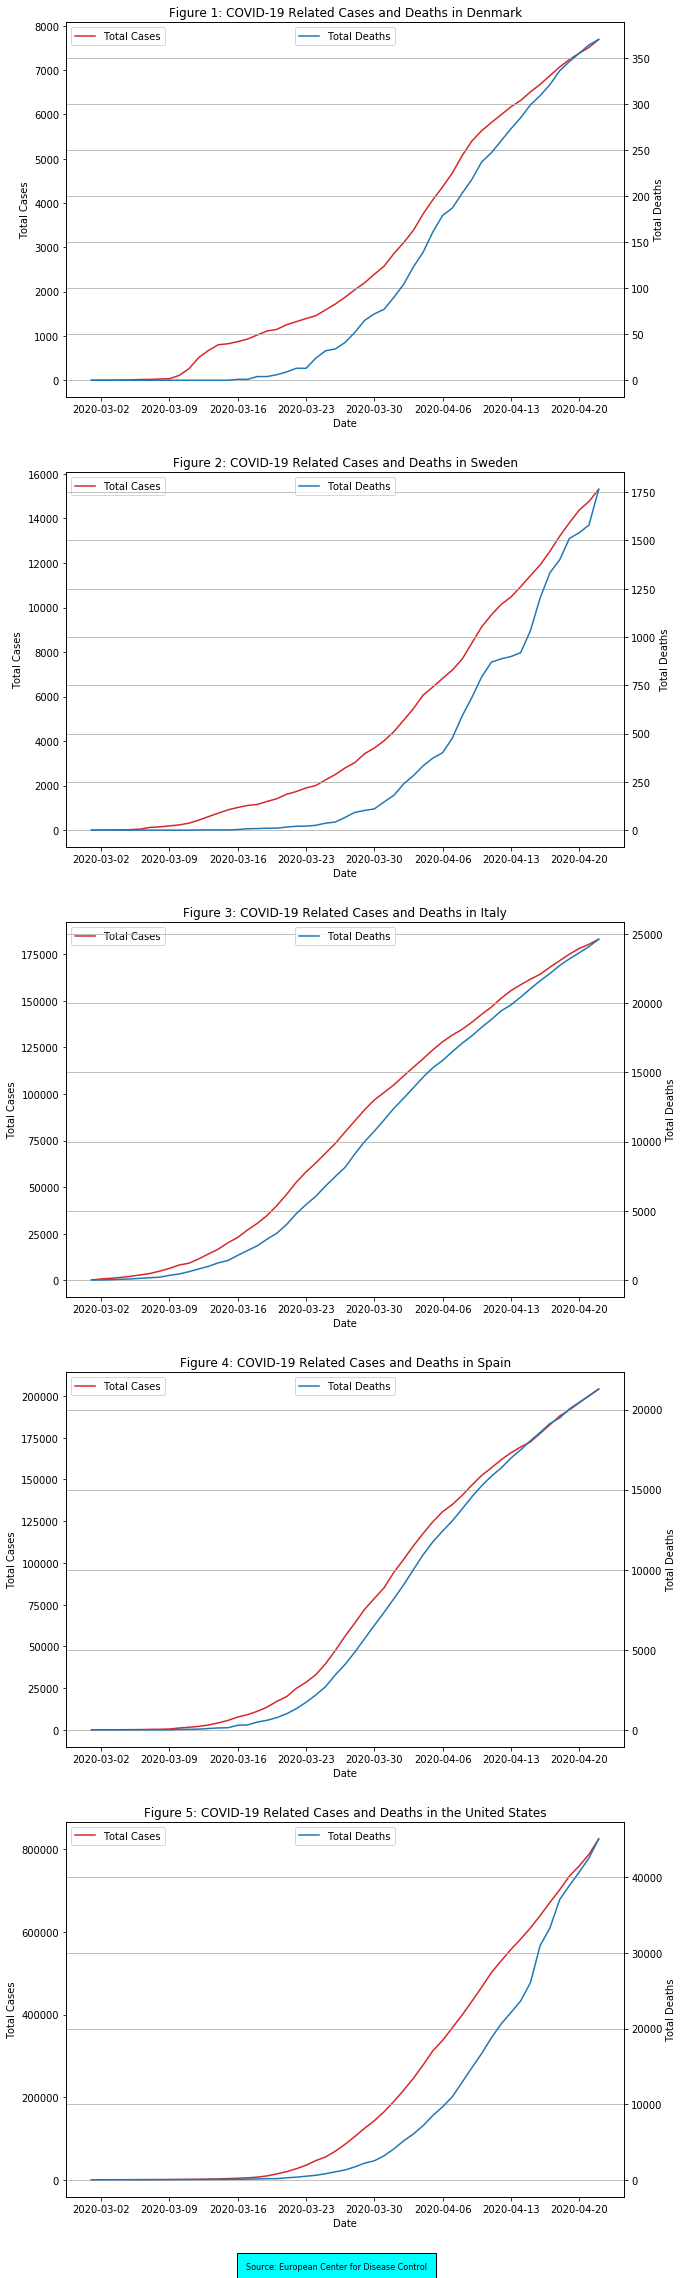

In [178]:
fig = plt.figure(figsize=(10,40))

color = 'tab:red'
ax = fig.add_subplot(5,1,1)
ax.plot(covid_ref['DNK cases'], color=color, label='Total Cases')
ax.set_ylabel('Total Cases')
ax.set_xlabel('Date')
ax.legend(loc='upper left')

ax2 = ax.twinx()

color = 'tab:blue'
ax2.set_ylabel('Total Deaths')
ax2.plot(covid_ref['DNK deaths'], color=color, label='Total Deaths')
ax2.set_xlabel('Date')
ax2.grid(True)
ax2.legend(loc='upper center')
plt.title('Figure 1: COVID-19 Related Cases and Deaths in Denmark')

color = 'tab:red'
ax = fig.add_subplot(5,1,2)
ax.plot(covid_ref['SWE cases'], color=color, label='Total Cases')
ax.set_ylabel('Total Cases')
ax.set_xlabel('Date')
ax.legend(loc='upper left')

ax2 = ax.twinx()

color = 'tab:blue'
ax2.set_ylabel('Total Deaths')
ax2.plot(covid_ref['SWE deaths'], color=color, label='Total Deaths')
ax2.set_xlabel('Date')
ax2.grid(True)
ax2.legend(loc='upper center')
plt.title('Figure 2: COVID-19 Related Cases and Deaths in Sweden')

color = 'tab:red'
ax = fig.add_subplot(5,1,3)
ax.plot(covid_ref['ITA cases'], color=color, label='Total Cases')
ax.set_ylabel('Total Cases')
ax.set_xlabel('Date')
ax.legend(loc='upper left')

ax2 = ax.twinx()

color = 'tab:blue'
ax2.set_ylabel('Total Deaths')
ax2.plot(covid_ref['ITA deaths'], color=color, label='Total Deaths')
ax2.set_xlabel('Date')
ax2.grid(True)
ax2.legend(loc='upper center')
plt.title('Figure 3: COVID-19 Related Cases and Deaths in Italy')

color = 'tab:red'
ax = fig.add_subplot(5,1,4)
ax.plot(covid_ref['ESP cases'], color=color, label='Total Cases')
ax.set_ylabel('Total Cases')
ax.set_xlabel('Date')
ax.legend(loc='upper left')

ax2 = ax.twinx()

color = 'tab:blue'
ax2.set_ylabel('Total Deaths')
ax2.plot(covid_ref['ESP deaths'], color=color, label='Total Deaths')
ax2.set_xlabel('Date')
ax2.grid(True)
ax2.legend(loc='upper center')
plt.title('Figure 4: COVID-19 Related Cases and Deaths in Spain')

color = 'tab:red'
ax = fig.add_subplot(5,1,5)
ax.plot(covid_ref['USA cases'], color=color, label='Total Cases')
ax.set_ylabel('Total Cases')
ax.set_xlabel('Date')
ax.legend(loc='upper left')

ax2 = ax.twinx()

color = 'tab:blue'
ax2.set_ylabel('Total Deaths')
ax2.plot(covid_ref['USA deaths'], color=color, label='Total Deaths')
ax2.set_xlabel('Date')
ax2.grid(True)
ax2.legend(loc='upper center')
plt.title('Figure 5: COVID-19 Related Cases and Deaths in the United States')
plt.figtext(0.5, 0.1, "Source: European Center for Disease Control", ha="center", fontsize=8, bbox={"facecolor":"cyan", "alpha":1, "pad":9})

plt.show()

In order to combat the outbreak of COVID-19, the analyzed countries have adopted several approaches varying in strictness. Plotting the number recorded cases and deaths against time for the months of March and April can help us understand the spread of COVID-19 in the selected countries. The graphical analysis is relevant, as the approaches aim to avoid exponential growth in the spread of COVID-19. In our case, exponential growth would occur when every contaminated individual infects *more* than 1 person.

The initial growth in the number of reported cases in Denmark appears to decline significantly when compared to Sweden which data exhibits closer to expotential growth. This could both be due to the strict policy with respect to social gatherings but also be related to the testing strategy, where Denmark has been criticized for lack of testing. Levels of testing in Denmark have been increasing through late March and April, which could explain the later surge in the growth rate in Danish COVID-19 related cases - however a clear downwards shift in recorded cases can be seen throughout April. Based on Figure 1 it appears Denmark has avoided the threat of exponential growth more so than Sweden.

The numbers for Italy and Spain could both imply exponential growth in both the number of reported cases as well as deaths. We note Italy experienced severe growth in the number of COVID-19 patients earlier than Spain. The numbers for late March could imply a downturn in the growth of COVID-19 related cases in both Italy and Spain and a potential adjustment towards linear growth.

Although data for the United States implies the outbreak hit the country to a certain degree of severety later than the other countries in our data, the alarming growth in number of reported cases and deaths has secured the United States' position as the epicentre of the COVID-19 outbreak as measured by number of reported cases and deaths. This could be due to the lack of strict policy concerning e.g. social distancing and shutdowns as well as the significant increase in testing in the country.

**Plotting log-scaled confirmed cases of COVID-19**

A way of comparing the rate of exponetial growth between the countries is to plot the recorded COVID-19 related number on a logarithmic scale. A flatter curve indicates a decreasing growth rate in the number of cases and deaths.

Note: The following 4 graphs are plotted using bokeh plot tools. As such, every plot will appear in a new browser-tab and require connection to the internet.

A more elegant solution (first plot) enables the hover tool, however to enable a legend (with the ability of hiding a chosen contry) a less elegant approach is also presented (second plot).

In [166]:
#Plotting log-scale number of cases for the selected countries. Hover-tool on.

from datetime import datetime
from bokeh.io import output_file, show
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.transform import factor_cmap, factor_mark
from bokeh.plotting import figure, output_file, show

source = ColumnDataSource(covid)
source.add(covid['date'].apply(lambda d: d.strftime('%Y-%m-%d')), 'date_formatted')

COUNTRIES = ['DNK', 'ESP', 'ITA', 'SWE', 'USA']
MARKERS = ['hex', 'circle_x', 'triangle', 'square', 'circle']

p = figure(title='Accumulated Number of Confirmed COVID-19 Cases', x_axis_type='datetime', 
           x_axis_label='Date', y_axis_label='Log Cases', y_axis_type="log", plot_height=400, plot_width=700,
           tools=[HoverTool(tooltips=[('Country','@country'),('Confirmed Cases','@total_cases' ), ('Date','@date_formatted')])])

p.scatter("date", "total_cases", source=source, fill_alpha=0.4, size=6,
          marker=factor_mark('country', MARKERS, COUNTRIES),
          color=factor_cmap('country', 'Category10_5', COUNTRIES))

output_file("COVID19_1.html", title="Accumulated Number of Confirmed COVID-19 Cases")

show(p)

In [167]:
#Plotting log-scale number of cases for the selected countries. Hover-tool and series-hiding on.

from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource, CDSView, GroupFilter, HoverTool

source = ColumnDataSource(covid)
source.add(covid['date'].apply(lambda d: d.strftime('%Y-%m-%d')), 'date_formatted')

USA = CDSView(source=source, filters=[GroupFilter(column_name='country', group='USA')])
DNK = CDSView(source=source, filters=[GroupFilter(column_name='country', group='DNK')])
SWE = CDSView(source=source, filters=[GroupFilter(column_name='country', group='SWE')])
ITA = CDSView(source=source, filters=[GroupFilter(column_name='country', group='ITA')])
ESP = CDSView(source=source, filters=[GroupFilter(column_name='country', group='ESP')])

p = figure(title='Total Confirmed COVID-19 Cases (Click on legend entries to hide the corresponding datapoints)', x_axis_type='datetime', 
           x_axis_label='Date', y_axis_label='Log Cases', y_axis_type="log", plot_height=400, plot_width=700,
           tools=[HoverTool(tooltips=[('Country','@country'),('Confirmed Cases','@total_cases' ), ('Date','@date_formatted')])])

p.circle(x='date', y='total_cases', source=source, view=USA,
         size=6, color='red', alpha=0.4, legend='USA')
p.square(x='date', y='total_cases', source=source, view=DNK,
         size=6, color='green', alpha=0.4, legend='DNK')
p.triangle(x='date', y='total_cases', source=source, view=SWE,
         size=6, color='purple', alpha=0.4, legend='SWE')
p.circle_x(x='date', y='total_cases', source=source, view=ITA,
         size=6, color='black', alpha=0.4, legend='ITA')
p.hex(x='date', y='total_cases', source=source, view=ESP,
         size=6, color='blue', alpha=0.4, legend='ESP')

p.legend.location = "top_left"
p.legend.click_policy="hide"
output_file("COVID19_2.html", title="Total Confirmed COVID-19 Cases (Click on legend entries to hide the corresponding datapoints")
show(p)

**Deaths**

In [168]:
#Plotting log-scale number of cases for the selected countries. Hover-tool on.

from bokeh.io import output_file, show
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.transform import factor_cmap, factor_mark
from bokeh.plotting import figure, output_file, show

source = ColumnDataSource(covid)
source.add(covid['date'].apply(lambda d: d.strftime('%Y-%m-%d')), 'date_formatted')

COUNTRIES = ['DNK', 'ESP', 'ITA', 'SWE', 'USA']
MARKERS = ['hex', 'circle_x', 'triangle', 'square', 'circle']

p = figure(title='Total Number of COVID-19 Deaths', x_axis_type='datetime', 
           x_axis_label='Date', y_axis_label='Log Deaths', y_axis_type="log", plot_height=400, plot_width=700,
           tools=[HoverTool(tooltips=[('Country','@country'),('Deaths','@total_deaths' ), ('Date','@date_formatted')])])

p.scatter("date", "total_deaths", source=source, fill_alpha=0.3, size=6,
          marker=factor_mark('country', MARKERS, COUNTRIES),
          color=factor_cmap('country', 'Category10_5', COUNTRIES))

output_file("COVID19_3.html", title="Total Number of COVID-19 Deaths")

show(p)

In [173]:
#Plotting log-scale number of cases for the selected countries. Hover-tool and series-hiding on.

from datetime import datetime
from bokeh.io import output_file, show
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.transform import factor_cmap, factor_mark
from bokeh.plotting import figure, output_file, show

source = ColumnDataSource(covid)
source.add(covid['date'].apply(lambda d: d.strftime('%Y-%m-%d')), 'date_formatted')

USA = CDSView(source=source, filters=[GroupFilter(column_name='country', group='USA')])
DNK = CDSView(source=source, filters=[GroupFilter(column_name='country', group='DNK')])
SWE = CDSView(source=source, filters=[GroupFilter(column_name='country', group='SWE')])
ITA = CDSView(source=source, filters=[GroupFilter(column_name='country', group='ITA')])
ESP = CDSView(source=source, filters=[GroupFilter(column_name='country', group='ESP')])

p = figure(title='Total Number of COVID-19 Deaths (Click on legend entries to hide the corresponding datapoints)', x_axis_type='datetime', 
           x_axis_label='Date', y_axis_label='Log Deaths', y_axis_type="log", plot_height=400, plot_width=700, 
           tools=[HoverTool(tooltips=[('Country','@country'),('Deaths','@total_deaths' ), ('Date','@date_formatted')])])

p.circle(x='date', y='total_deaths', source=source, view=USA,
         size=6, color='red', alpha=0.4, legend='USA')
p.square(x='date', y='total_deaths', source=source, view=DNK,
         size=6, color='green', alpha=0.4, legend='DNK')
p.triangle(x='date', y='total_deaths', source=source, view=SWE,
         size=6, color='purple', alpha=0.4, legend='SWE')
p.circle_x(x='date', y='total_deaths', source=source, view=ITA,
         size=6, color='black', alpha=0.4, legend='ITA')
p.hex(x='date', y='total_deaths', source=source, view=ESP,
         size=6, color='blue', alpha=0.4, legend='ESP')

p.legend.location = "top_left"
p.legend.click_policy="hide"
output_file("COVID19_4.html", title="Total Number of COVID-19 Deaths (Click on legend entries to hide the corresponding datapoints")
show(p)

The above plots confirm some of the points made from Figures 1-5.

When comparing the two selected Scandinavian countries, Denmark and Sweden, it is clear that the outbreak is more severe in Sweden. This is particularly evident when comparing the number of total deaths - the flattening of the curve appears more significantly and earlier.

The growth in both number of cases and deaths in Italy and Spain appears critical at its peak, and as noted slightly delayed in Spain - both countries' curves seem to be flattening out to some extent.

The numbers and plots for the United States tell their own story - there is little evidence of the outbreak slowing.

**COVID-19 and the stock market**

The pandemic has had a significant effect on the global economy and as such the stock market. Due to availability of daily data we wish to consider the S&P 500 index and the development of COVID-19 in the United States.

**Reading the relevant data** for the S&P500 stock index in the period considered (March and April 2020). 

In [145]:
SP500 = pd.read_excel('SP500.xls')
SP500['country']='USA'
SP500.head()

,date,SP500,country
0,2020-03-02,3090.23,USA
1,2020-03-03,3003.37,USA
2,2020-03-04,3130.12,USA
3,2020-03-05,3023.94,USA
4,2020-03-06,2972.37,USA


**Merging** the data with COVID-19 data in the United States. As such, we merge by data and country in the original 'covid' dataset.

In [146]:
covid_stocks = pd.merge(covid, SP500, how='inner',on=['date', 'country'])
covid_stocks.head()

,date,day,month,cases,deaths,country,continentExp,total_cases,total_deaths,SP500
0,2020-03-02,2,3,20,1,USA,America,23,2,3090.23
1,2020-03-03,3,3,14,4,USA,America,37,6,3003.37
2,2020-03-04,4,3,22,3,USA,America,59,9,3130.12
3,2020-03-05,5,3,34,2,USA,America,93,11,3023.94
4,2020-03-06,6,3,74,1,USA,America,167,12,2972.37
5,2020-03-09,9,3,121,4,USA,America,488,21,2746.56
6,2020-03-10,10,3,200,5,USA,America,688,26,2882.23
7,2020-03-11,11,3,271,2,USA,America,959,28,2741.38
8,2020-03-12,12,3,287,2,USA,America,1246,30,2480.64
9,2020-03-13,13,3,351,10,USA,America,1597,40,2711.02


**Plotting the data**

Note: The following 4 graphs are plotted using bokeh plot tools. As such, every plot will appear in a new browser-tab.

We plot the data for the S&P500 stock market below such as to get a general idea of the development in the index.

In [174]:
#Plotting log-scale number of cases for the selected countries. Hover-tool and series-hiding on.

from datetime import datetime
from bokeh.io import output_file, show
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.transform import factor_cmap, factor_mark
from bokeh.plotting import figure, output_file, show

source1 = ColumnDataSource(covid_stocks)
source1.add(covid_stocks['date'].apply(lambda d: d.strftime('%Y-%m-%d')), 'date_formatted')

p = figure(title='SP500', x_axis_type='datetime', 
           x_axis_label='Date', y_axis_label='SP500', plot_height=400, plot_width=700, 
           tools=[HoverTool(tooltips=[('SP500','@SP500' ), ('Date','@date_formatted')])])

p.circle(x='date', y='SP500', source=source1,
         size=8, color='red', alpha=0.4)

output_file("COVID19_5.html", title="SP500")
show(p)

We observe a sharp downturn in the index in early March as the pandemic critically reaches the United States. Throughout the rest of March and April a degree of recovery is observed.

In [176]:
#Plotting log-scale number of cases for the selected countries. Hover-tool and series-hiding on.

from datetime import datetime
from bokeh.io import output_file, show
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.transform import factor_cmap, factor_mark
from bokeh.plotting import figure, output_file, show

source1 = ColumnDataSource(covid_stocks)
source1.add(covid_stocks['date'].apply(lambda d: d.strftime('%Y-%m-%d')), 'date_formatted')

p = figure(title='SP500', x_axis_label='Daily Confirmed Cases of Covid-19', y_axis_label='SP500', plot_height=400, plot_width=700, 
           tools=[HoverTool(tooltips=[('SP500','@SP500' ), ('Date','@date_formatted'), ('Cases','@cases' ), ('Deaths','@deaths' )])])

p.circle(x='cases', y='SP500', source=source1,
         size=8, color='blue', alpha=0.4)

output_file("COVID19_6.html", title="Scatter SP500 COVID-Cases")
show(p)

With the daily number of recorded cases below approx. 10.000, a clear negative correlation between number of confirmed cases and the S&P500 can be observed. As we noted in the first graph, the S&P500 recovers to some extent in late March - this coincides with extremely large numbers of daily recorded cases, which is why a seemingly positive correlation between cases and the S&P500 index can be seen - this correlation can not be interpreted as the isolated effect of COVID-19 cases in the United States on the S&P500 index. The later increase in the stock markted could be due to several macro and socioeconomic factors.